# Utils

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as sts


def read_data(path, iters=None, default_batchsize=100, scale='Eps'):
    df = pd.read_csv(path, encoding='utf-8')
    if iters: df = df.loc[:iters, :]
    if not 'BatchSize' in df: df['BatchSize'] = default_batchsize
    if not 'AvgRet' in df: df['AvgRet'] = df['AverageReturn']
    if not 'EpsThisIter' in df: df['EpsThisIter'] = df['BatchSize']
    df['EpsSoFar'] = np.cumsum(df['EpsThisIter'])
    if 'SamplesThisIter' in df: df['SamplesSoFar'] = np.cumsum(df['SamplesThisIter'])
    df['CumAvgRet'] = np.cumsum(df['AvgRet']*df[scale+'ThisIter'])/np.sum(df[scale+'ThisIter'])
    return df

def moments(dfs):
    concat_df = pd.concat(dfs, axis=1)
    mean_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).mean()
    std_df = pd.concat(dfs, axis=1).groupby(by=concat_df.columns, axis=1).std()
    return mean_df, std_df

def plot_all(dfs, key='AvgRet', ylim=None, scale='Samples'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for df in dfs:
        value = df[key]
        ax.plot(df[scale+'SoFar'], value)
    return fig

def plot_ci(dfs, conf=0.95, key='AvgRet', ylim=None, scale='Eps'):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    mean = mean_df[key]
    std = std_df[key]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(mean_df[scale+'SoFar'], mean)
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    ax.fill_between(mean_df[scale+'SoFar'], interval[0], interval[1], alpha=0.3)
    if ylim: ax.set_ylim(ylim)
    return fig

def compare(candidates, conf=0.95, key='AvgRet', ylim=None, xlim=None, scale='Eps'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    entries = []
    for candidate_name in candidates:
        entries.append(candidate_name)
        dfs = candidates[candidate_name]
        n_runs = len(dfs)
        mean_df, std_df = moments(dfs)
        mean = mean_df[key]
        std = std_df[key]
        ax.plot(mean_df[scale+'SoFar'], mean)
        interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
        ax.fill_between(mean_df[scale+'SoFar'], interval[0], interval[1], alpha=0.3)
        print(candidate_name, end=': ')
        print_ci(dfs, conf)
    ax.legend(entries, loc='upper left')
    if ylim: ax.set_ylim(ylim)
    if xlim: ax.set_xlim(xlim)
    return fig

def plot_data(path, key='VanillaAvgRet'):
    xlabel='Iteration'
    df = pd.read_csv(path)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    fig.suptitle(key)
    mean = df[key]
    ax.plot(df[xlabel], mean)
    return fig

def print_ci(dfs, conf=0.95, key='CumAvgRet'):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    total_horizon = np.sum(mean_df['AvgEpLen'])
    mean = mean_df[key][len(mean_df)-1]
    std = std_df[key][len(mean_df)-1]
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    print('%f \u00B1 %f\t[%f, %f]\t total horizon: %d' % (mean, std, interval[0], interval[1], int(total_horizon)))

def save_ci(dfs, conf=0.95, key='AvgRet', ylim=None, scale='Eps', horizon=500, filename='prova.csv'):
    n_runs = len(dfs)
    mean_df, std_df = moments(dfs)
    mean = mean_df[key]
    std = std_df[key]
    interval = sts.t.interval(conf, n_runs-1,loc=mean,scale=std/np.sqrt(n_runs))
    low = pd.Series(interval[0])
    high = pd.Series(interval[1])
    iteration = pd.Series(horizon*np.array(range(len(mean))))
    df_out = pd.DataFrame(list(zip(iteration, mean, std, low, high)), columns=['iteration', 'mean', 'std', 'low', 'up'])
    df_out.to_csv(filename, index=False)


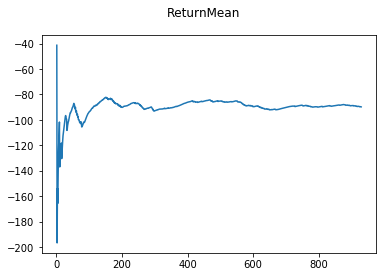

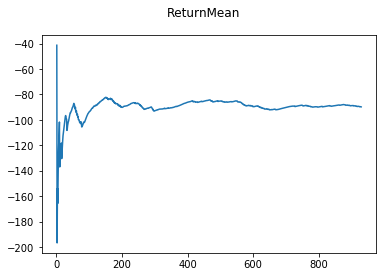

In [19]:
path = "./logs/double_sampling_and_back_LQG1D-V0_delta=0.2_seed=1_1543221639.2823846.csv"
plot_data(path, key='ReturnMean')